# Определение возраста покупателей

## Описание проекта

Супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

## Цель проекта

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Описание данных

- `file_name` - имя файла с изображением
- `real_age` - возраст

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(rescale=1./255)

datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                    directory='/datasets/faces/final_files/',
                                                    x_col='file_name',
                                                    y_col='real_age',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='raw',
                                                    seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.shape

(7591, 2)

In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


В датасете представлены 7591 фотография с указанием возраста.

*Возраст варьируется от 1 года до 100 лет*, будем учитывать это при построении гистограммы распределения возрастов.

*Медианный возраст равен 29 годам*, но в датасете представлено больше фотографий более старшей группы, поэтому средний возраст смещён в сторону 31 года.

Так же интересен разброс в 17 лет, что достаточно много. Думаю это связано с тем, что 75% фотографий людей до 41 года включительно, и всего 25% от 41 до 100 лет.

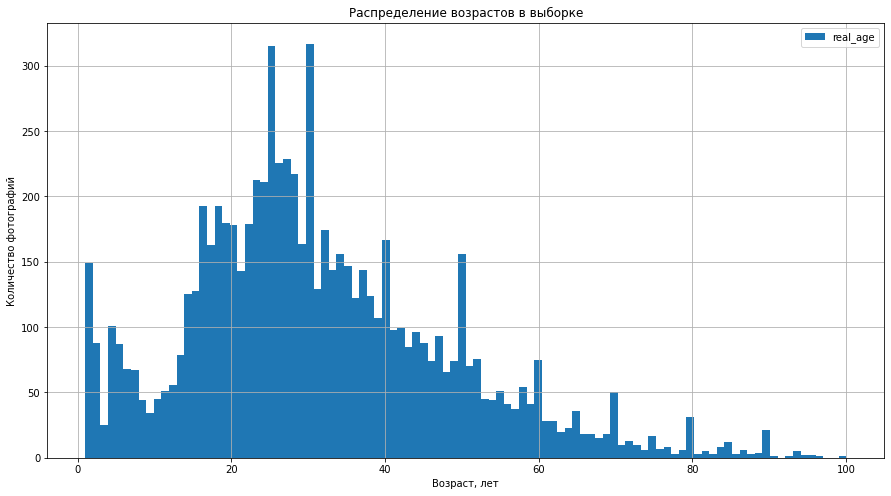

In [6]:
labels.plot(kind='hist', figsize=(15, 8), bins=100, grid=True)
plt.title('Распределение возрастов в выборке')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество фотографий')
plt.show()

На графике можно заметить выбросы для таких возрастных групп:
- 1 год
- 18 лет
- 25 лет
- 30 лет

И далее для каждого возраста, кратного 10, возможно для части фотографий указывался примерный возраст, а не точный, что может повлиять на результат обучения модели.

Выведем фотографии из датасета для изучения.

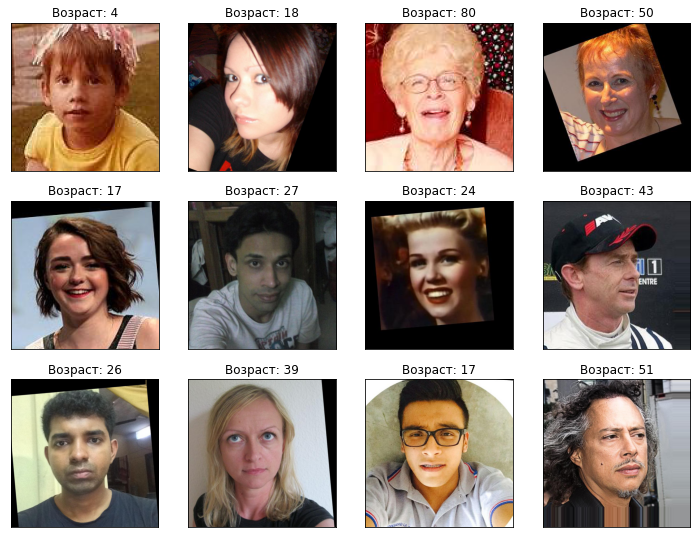

In [7]:
fig = plt.figure(figsize=(10, 10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    image = Image.open('/datasets/faces/final_files/'+ str(i).rjust(6, "0")+'.jpg')
    plt.imshow(np.array(image)) 
    plt.title('Возраст: {}'.format(labels.real_age[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Выводы**
- В датасете представлены 7591 фотография с указанием возраста.
- Возраст варьируется от 1 до 100 лет.
- 50% фотографий представлены с возрастной группой от 20 до 41 года, так же много фотографий детей до 18 лет. Скорее всего это негативно скажется на предсказании возраста людей старшего поколения.
- На фотографиях в области лица присутсвуют посторонние предметы, например очки. Так же имеются фотографии в профиль и плохого качества.

## Обучение модели

Будем обучать модель ResNet50 с такими параметрами:
- Не будем замораживать backbone, т.к. у нас достаточно данных, чтобы модель не переобучалась.
- Оптимайзер Adam, learning rate = 0.00001
- Функция активации ReLu
- 1 выходной нейрон
- Функция потерь MSE
- Метрика MAE

При предобработке изображений сдвинем яркость и используем горизонтальное отображение.

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

#!/usr/bin/env python
# coding: utf-8

# In[ ]:


import numpy as np
import pandas as pd

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path+'labels.csv') 
    train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.25,
                                   horizontal_flip=True,
                                   brightness_range=(0.8, 1.))

    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
      directory=path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      subset='training',
      seed=12345)
    return train_datagen_flow



def load_test(path):
    labels = pd.read_csv(path+'labels.csv') 
    test_datagen = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    return test_datagen_flow



def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(1, activation='relu')) 
    
    optimizer = Adam(lr=0.00001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 140s - loss: 823.3298 - mae: 24.0968 - val_loss: 1105.6234 - val_mae: 28.7163
Epoch 2/10
178/178 - 49s - loss: 207.6690 - mae: 10.9655 - val_loss: 1118.0710 - val_mae: 28.9364
Epoch 3/10
178/178 - 49s - loss: 97.3341 - mae: 7.3739 - val_loss: 926.1702 - val_mae: 25.7110
Epoch 4/10
178/178 - 50s - loss: 64.0011 - mae: 6.0352 - val_loss: 205.9466 - val_mae: 10.5612
Epoch 5/10
178/178 - 50s - loss: 47.0759 - mae: 5.1707 - val_loss: 110.1303 - val_mae: 8.0942
Epoch 6/10
178/178 - 50s - loss: 34.1857 - mae: 4.4689 - val_loss: 85.0624 - val_mae: 6.9496
Epoch 7/10
178/178 - 50s - loss: 28.4864 - mae: 4.0620 - val_loss: 83.7364 - val_mae: 6.9360
Epoch 8/10
178/178 - 51s - loss: 23.8669 - mae: 3.6991 - val_loss: 83.9348 - val_mae: 6.9106
Epoch 9/10
178/178 - 50s - loss: 19.9281 - mae: 3.4330 - val_loss: 81.1359 - val_mae: 6.7186
Epoch 10/10
178/178 - 51s - loss: 17.0778 - mae: 3.1890 - val_loss: 81.9199 - val_mae: 6.7874

60/60 - 10s - loss: 81.9199 - mae: 6.7874
Test MAE: 6.7874

```

## Анализ обученной модели

Цель проекта была выполнена, модель с метрикой МАЕ не более 8 была построена и **итоговый МАЕ = 6.78**

Датасет проекта состоял из 7591 изображения с указанием возраста. Возраст варьировался от 1 года до 100 лет. Больше всего изображений было представлено в возрастной группе от 21 года до 40 лет.

Я использовала предобученую модель ResNet50 с такими параметрами:
- Не будем замораживать backbone, т.к. у нас достаточно данных, чтобы модель не переобучалась.
- Оптимайзер Adam, learning rate = 0.00001
- Функция активации ReLu
- 1 выходной нейрон
- Функция потерь MSE
- Метрика MAE

При предобработке изображений сдвинем яркость и используем горизонтальное отображение.


**Вывод**

Разница почти в 7 лет с целевым значением может быть критична, особенно если мы говорим о контроле продаж алкоголя. 

Данная модель может быть использована для анализа и предложения товаров, которые могут заинтересовать покупателей, но в том случае, если мы не рассматриваем детей, всё-таки в 8 лет и в 15 лет предпочтения у детей разные. Но со взрослыми это бы отлично сработало.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы